In [10]:
!pip install pyalgotrading
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peewee: filename=peewee-3.17.8-py3-none-any.whl size=139017 sha256=78b0a819ac568138603e28b6aef8f7c91682dc8e0f4955a32bd22073b028eb5b
  Stored in directory: /Users/sonukumar/Library/Caches/pip/wheels/8f/65/34/456800445efeafb05164fe95285c70e81ba1d96bae30f43917
Successfully built peewee


[*********************100%***********************]  1 of 1 completed


Initial Balance: $10000
Final Balance: $357800.24
Total Profit/Loss: $347800.24


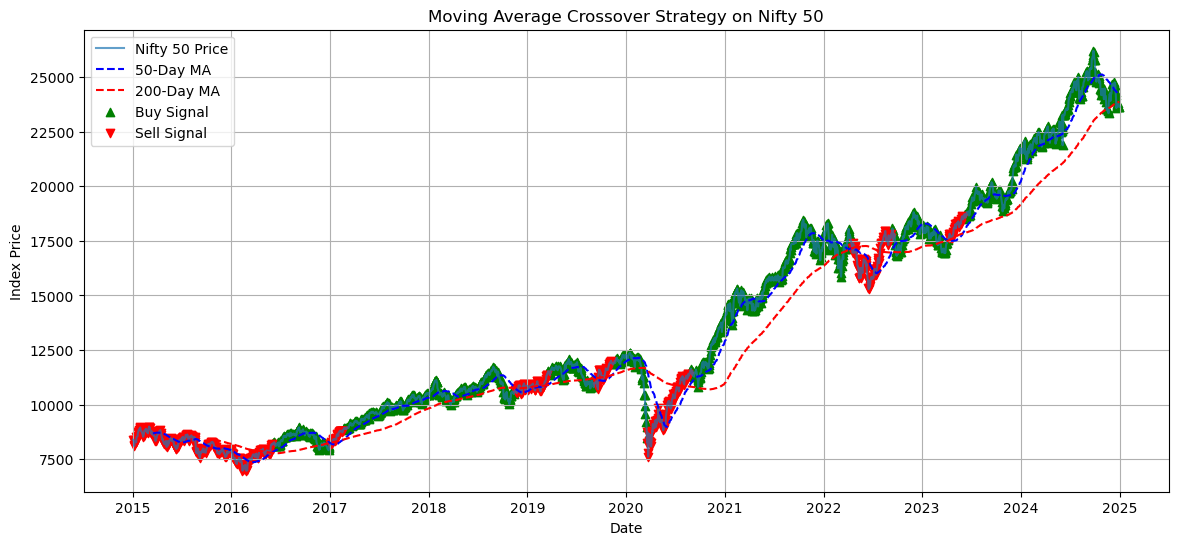

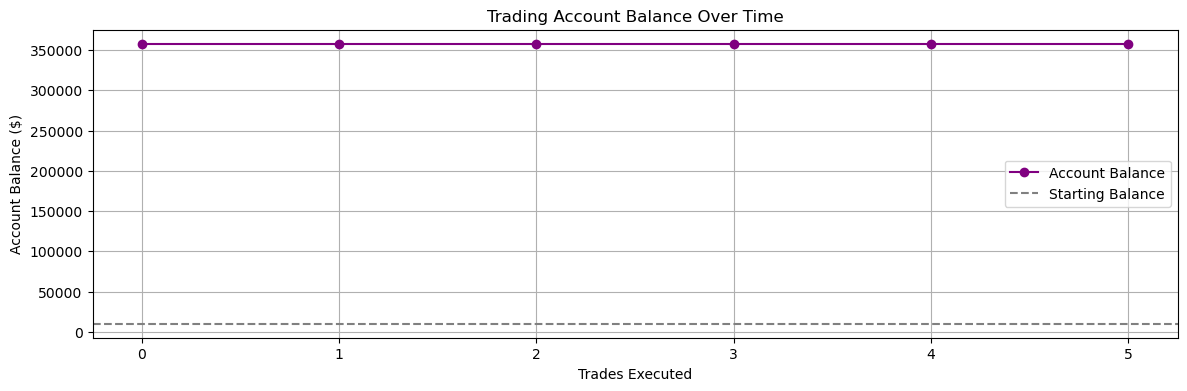

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define stock and time period
stock_symbol = "^NSEI"  # Nifty 50 symbol on Yahoo Finance
start_date = "2015-01-01"
end_date = "2025-01-01"

# Fetch historical stock data
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate Moving Averages
df["50_MA"] = df["Close"].rolling(window=50).mean()
df["200_MA"] = df["Close"].rolling(window=200).mean()

# Generate Buy (Call) and Sell (Put) Signals
df["Signal"] = np.where(df["50_MA"] > df["200_MA"], 1, -1)  # 1 = Buy Call, -1 = Buy Put

# Track positions and profit/loss
initial_balance = 10000  # Starting capital in USD
balance = initial_balance
trade_log = []  # Store trade details
balance_over_time = []  # Store balance evolution

position = None
entry_price = None

# Iterate through data to execute strategy
for i in range(1, len(df)):
    prev_signal = df["Signal"].iloc[i - 1]
    curr_signal = df["Signal"].iloc[i]
    close_price = df["Close"].iloc[i]

    if prev_signal != curr_signal:  # A crossover occurred
        if curr_signal == 1:  # Golden Cross (Buy Call)
            position = "Call"
            entry_price = close_price
            trade_log.append({"Date": df.index[i], "Action": "Buy Call", "Price": close_price})

        elif curr_signal == -1 and position == "Call":  # Death Cross (Sell Call, Buy Put)
            profit = (close_price - entry_price) * 100  # Assuming 1 contract (100 shares)
            balance += profit
            trade_log.append({"Date": df.index[i], "Action": "Sell Call", "Price": close_price, "Profit": profit})
            balance_over_time.append(balance)
            position = "Put"
            entry_price = close_price
            trade_log.append({"Date": df.index[i], "Action": "Buy Put", "Price": close_price})

        elif curr_signal == 1 and position == "Put":  # Golden Cross (Sell Put, Buy Call)
            profit = (entry_price - close_price) * 100
            balance += profit
            trade_log.append({"Date": df.index[i], "Action": "Sell Put", "Price": close_price, "Profit": profit})
            balance_over_time.append(balance)
            position = "Call"
            entry_price = close_price
            trade_log.append({"Date": df.index[i], "Action": "Buy Call", "Price": close_price})

# Convert trade log to DataFrame
trade_df = pd.DataFrame(trade_log)

# Ensure balance is a number, not a Series
final_balance = balance if isinstance(balance, (int, float)) else balance.iloc[-1]
profit_loss = final_balance - initial_balance

# Print Final Balance & Profit
print(f"Initial Balance: ${initial_balance}")
print(f"Final Balance: ${final_balance:.2f}")
print(f"Total Profit/Loss: ${profit_loss:.2f}")

# Plot Nifty 50 Price & Moving Averages
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Close"], label="Nifty 50 Price", alpha=0.7)
plt.plot(df.index, df["50_MA"], label="50-Day MA", linestyle="--", color="blue")
plt.plot(df.index, df["200_MA"], label="200-Day MA", linestyle="--", color="red")

# Highlight Buy/Sell Signals
buy_signals = df[df["Signal"] == 1]
sell_signals = df[df["Signal"] == -1]
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", label="Buy Signal", alpha=1)
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="red", label="Sell Signal", alpha=1)

plt.legend()
plt.title(f"Moving Average Crossover Strategy on Nifty 50")
plt.xlabel("Date")
plt.ylabel("Index Price")
plt.grid(True)
plt.show()

# Plot Profit/Loss Over Time
plt.figure(figsize=(14, 4))
plt.plot(balance_over_time, label="Account Balance", color="purple", linestyle="-", marker="o")
plt.axhline(y=initial_balance, color="gray", linestyle="--", label="Starting Balance")
plt.legend()
plt.title("Trading Account Balance Over Time")
plt.xlabel("Trades Executed")
plt.ylabel("Account Balance ($)")
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


Initial Balance: $10000
Final Balance: $135835.06
Total Profit/Loss: $125835.06


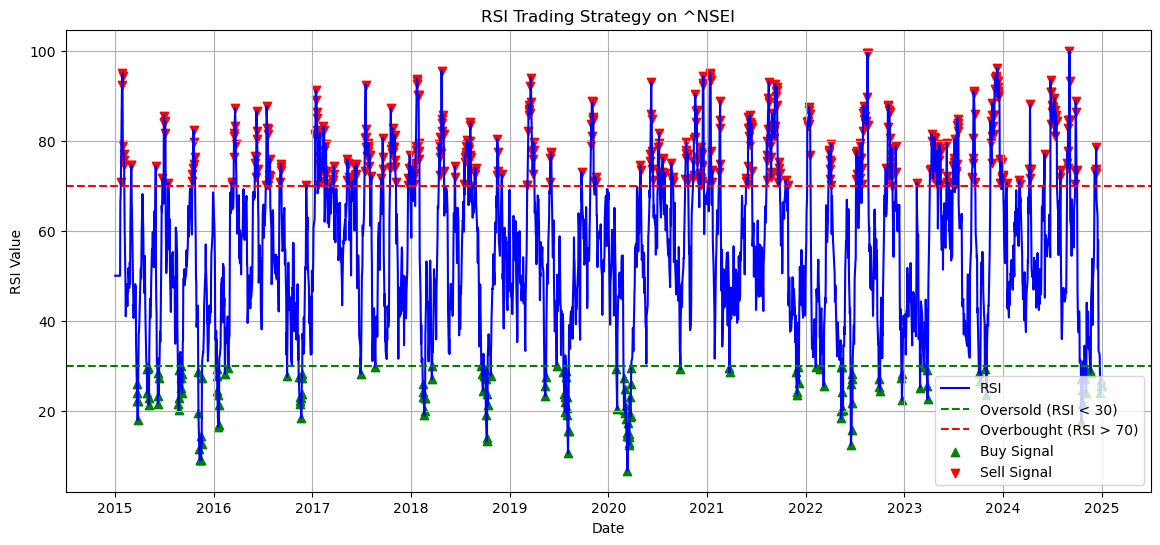

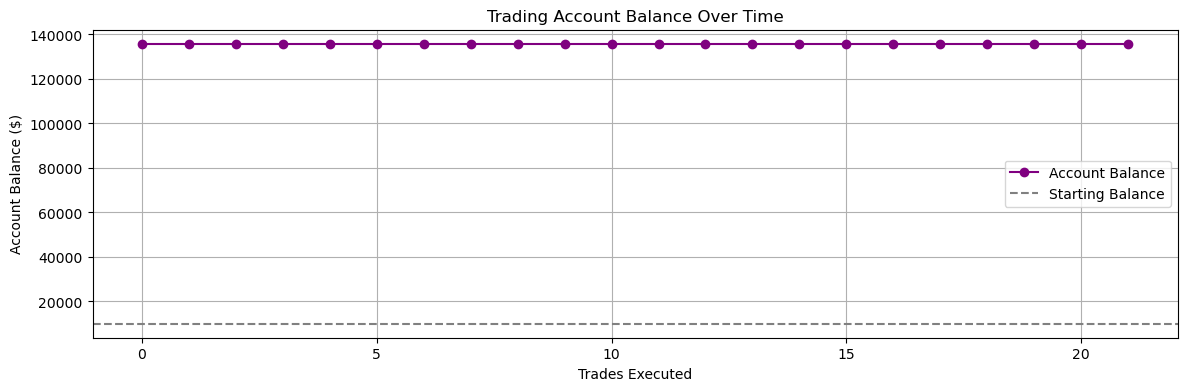

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define stock and time period
stock_symbol = "^NSEI"  # Nifty 50
start_date = "2015-01-01"
end_date = "2025-01-01"

# Fetch historical stock data
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Function to calculate RSI
def calculate_rsi(data, period=14):
    delta = data["Close"].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    return rsi.fillna(50)  # Fill NaN values with neutral RSI (50)

# Calculate RSI
df["RSI"] = calculate_rsi(df)

# Generate Buy and Sell Signals
df["Buy_Signal"] = np.where(df["RSI"] < 30, 1, 0)  # Buy when RSI < 30
df["Sell_Signal"] = np.where(df["RSI"] > 70, 1, 0)  # Sell when RSI > 70

# Track profit/loss
initial_balance = 10000
balance = initial_balance
position = None
trade_log = []
balance_over_time = []

for i in range(1, len(df)):
    close_price = df["Close"].iloc[i]

    if df["Buy_Signal"].iloc[i] == 1 and position is None:
        position = "Buy"
        entry_price = close_price
        trade_log.append({"Date": df.index[i], "Action": "Buy", "Price": close_price})

    elif df["Sell_Signal"].iloc[i] == 1 and position == "Buy":
        profit = (close_price - entry_price) * 100
        balance += profit
        trade_log.append({"Date": df.index[i], "Action": "Sell", "Price": close_price, "Profit": profit})
        balance_over_time.append(balance)
        position = None

# Convert trade log to DataFrame
trade_df = pd.DataFrame(trade_log)

# Ensure balance is a number
final_balance = balance if isinstance(balance, (int, float)) else balance.iloc[-1]
profit_loss = final_balance - initial_balance

# Print Final Balance & Profit
print(f"Initial Balance: ${initial_balance}")
print(f"Final Balance: ${final_balance:.2f}")
print(f"Total Profit/Loss: ${profit_loss:.2f}")

# Plot RSI with Buy/Sell Signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["RSI"], label="RSI", color="blue")
plt.axhline(y=30, color="green", linestyle="--", label="Oversold (RSI < 30)")
plt.axhline(y=70, color="red", linestyle="--", label="Overbought (RSI > 70)")

# Highlight Buy/Sell Signals
buy_signals = df[df["Buy_Signal"] == 1]
sell_signals = df[df["Sell_Signal"] == 1]
plt.scatter(buy_signals.index, buy_signals["RSI"], marker="^", color="green", label="Buy Signal", alpha=1)
plt.scatter(sell_signals.index, sell_signals["RSI"], marker="v", color="red", label="Sell Signal", alpha=1)

plt.legend()
plt.title(f"RSI Trading Strategy on {stock_symbol}")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.grid(True)
plt.show()

# Plot Profit/Loss Over Time
plt.figure(figsize=(14, 4))
plt.plot(balance_over_time, label="Account Balance", color="purple", linestyle="-", marker="o")
plt.axhline(y=initial_balance, color="gray", linestyle="--", label="Starting Balance")
plt.legend()
plt.title("Trading Account Balance Over Time")
plt.xlabel("Trades Executed")
plt.ylabel("Account Balance ($)")
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


Initial Balance: $10000
Final Balance: $780829.25
Total Profit/Loss: $770829.25


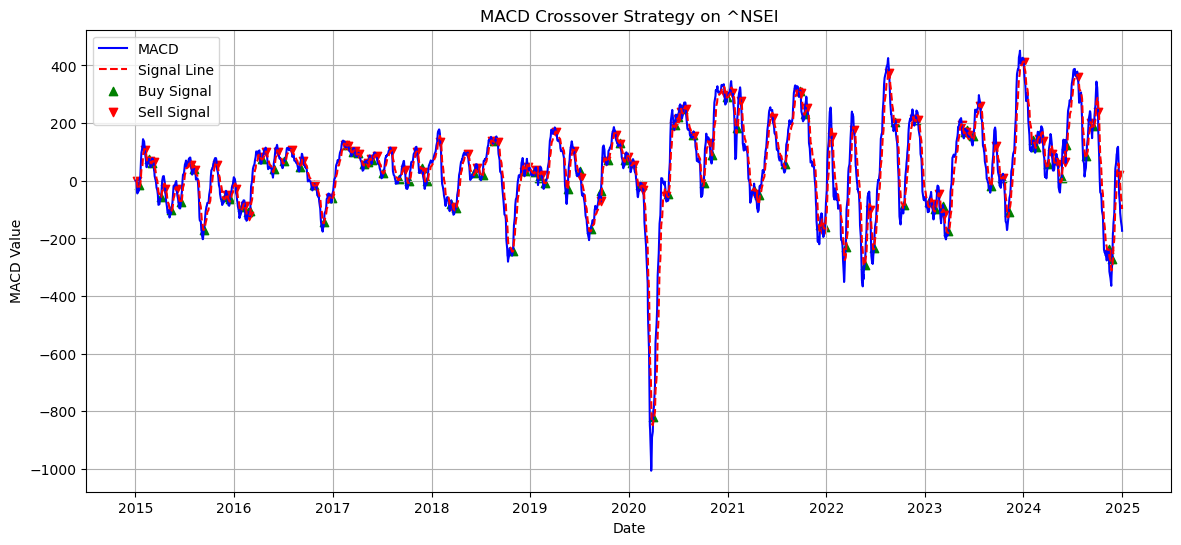

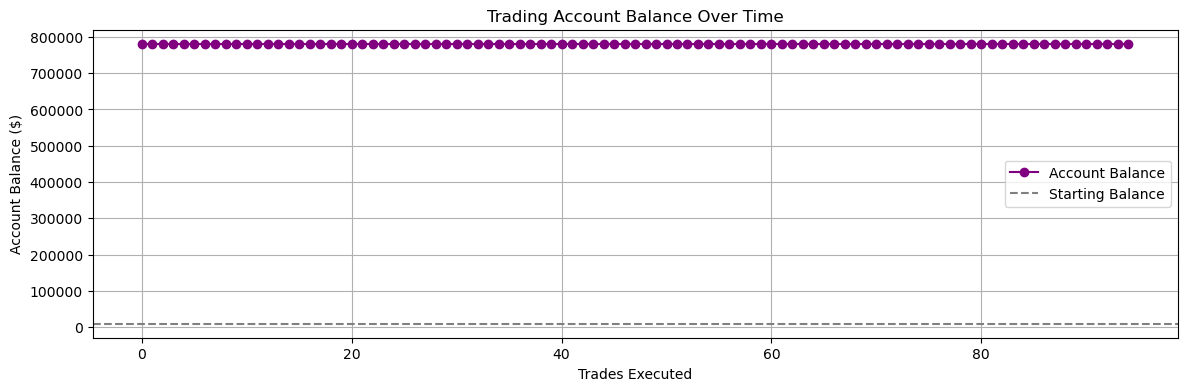

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define stock and time period
stock_symbol = "^NSEI"  # Nifty 50
start_date = "2015-01-01"
end_date = "2025-01-01"

# Fetch historical stock data
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate MACD and Signal Line
df["12_EMA"] = df["Close"].ewm(span=12, adjust=False).mean()  # 12-day EMA
df["26_EMA"] = df["Close"].ewm(span=26, adjust=False).mean()  # 26-day EMA
df["MACD"] = df["12_EMA"] - df["26_EMA"]  # MACD Line
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()  # Signal Line

# Generate Buy (Bullish Crossover) and Sell (Bearish Crossover) Signals
df["Buy_Signal"] = np.where((df["MACD"] > df["Signal"]) & (df["MACD"].shift(1) <= df["Signal"].shift(1)), 1, 0)
df["Sell_Signal"] = np.where((df["MACD"] < df["Signal"]) & (df["MACD"].shift(1) >= df["Signal"].shift(1)), 1, 0)

# Track profit/loss
initial_balance = 10000
balance = initial_balance
position = None
trade_log = []
balance_over_time = []

for i in range(1, len(df)):
    close_price = df["Close"].iloc[i]

    if df["Buy_Signal"].iloc[i] == 1 and position is None:
        position = "Buy"
        entry_price = close_price
        trade_log.append({"Date": df.index[i], "Action": "Buy", "Price": close_price})

    elif df["Sell_Signal"].iloc[i] == 1 and position == "Buy":
        profit = (close_price - entry_price) * 100
        balance += profit
        trade_log.append({"Date": df.index[i], "Action": "Sell", "Price": close_price, "Profit": profit})
        balance_over_time.append(balance)
        position = None

# Convert trade log to DataFrame
trade_df = pd.DataFrame(trade_log)

# Ensure balance is a number
final_balance = balance if isinstance(balance, (int, float)) else balance.iloc[-1]
profit_loss = final_balance - initial_balance

# Print Final Balance & Profit
print(f"Initial Balance: ${initial_balance}")
print(f"Final Balance: ${final_balance:.2f}")
print(f"Total Profit/Loss: ${profit_loss:.2f}")

# Plot MACD with Buy/Sell Signals
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["MACD"], label="MACD", color="blue")
plt.plot(df.index, df["Signal"], label="Signal Line", color="red", linestyle="--")

# Highlight Buy/Sell Signals
buy_signals = df[df["Buy_Signal"] == 1]
sell_signals = df[df["Sell_Signal"] == 1]
plt.scatter(buy_signals.index, buy_signals["MACD"], marker="^", color="green", label="Buy Signal", alpha=1)
plt.scatter(sell_signals.index, sell_signals["MACD"], marker="v", color="red", label="Sell Signal", alpha=1)

plt.legend()
plt.title(f"MACD Crossover Strategy on {stock_symbol}")
plt.xlabel("Date")
plt.ylabel("MACD Value")
plt.grid(True)
plt.show()

# Plot Profit/Loss Over Time
plt.figure(figsize=(14, 4))
plt.plot(balance_over_time, label="Account Balance", color="purple", linestyle="-", marker="o")
plt.axhline(y=initial_balance, color="gray", linestyle="--", label="Starting Balance")
plt.legend()
plt.title("Trading Account Balance Over Time")
plt.xlabel("Trades Executed")
plt.ylabel("Account Balance ($)")
plt.grid(True)
plt.show()